### Importing all necessary libraries

In [19]:
import numpy as np
import tensorflow as tf
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D
from keras.models import Model
import os
import numpy as np
import pandas as pd
from pyntcloud import PyntCloud
import open3d as o3d
from ConversionUtils import ConversionUtils
from Visualization import Visualization

### Converting STL to point cloud
**Only execute the next cell if the point cloud files do not exist in abc-dataset-ply/ directory**

In [10]:
files = sorted(ConversionUtils.list_files_in_directory("abc-dataset-stl/"))
for i in files:
    path = "abc-dataset-stl/" + i
    ConversionUtils.stl_to_ply(path)

### Converting point cloud to binary voxel arrays

In [11]:
directory = "abc-dataset-ply/"
files = sorted([filename for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))])
dataset = []

for i in files:
    path = os.path.join(directory, i)
    binvox = ConversionUtils.convert_to_binvox(path)
    dataset.append(binvox)

### Splitting dataset for training and testing

In [12]:
# Load your dataset into numpy arrays
dataset = np.array(dataset)

# Split your dataset into train and test datasets
train_dataset = dataset[:320]  # Adjust the number as needed
test_dataset = dataset[320:]   # The remaining data for testing

# Define the input shape
input_shape = (64, 64, 64, 1)

### Encoder

In [13]:
input_data = Input(shape=input_shape)
x = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(input_data)
x = MaxPooling3D((2, 2, 2), padding='same')(x)
x = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling3D((2, 2, 2), padding='same')(x)

### Decoder

In [14]:
x = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(encoded)
x = UpSampling3D((2, 2, 2))(x)
x = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
x = UpSampling3D((2, 2, 2))(x)
decoded = Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')(x)

### Training autoencoder, prediction done on test dataset

In [15]:
autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(train_dataset, train_dataset, epochs=40, batch_size=10, validation_data=(test_dataset, test_dataset))
reconstructed_data = autoencoder.predict(test_dataset)

Epoch 1/40
32/32 [==============================] - 11s 299ms/step - loss: 0.3761 - val_loss: 0.2185
Epoch 2/40
32/32 [==============================] - 9s 286ms/step - loss: 0.2913 - val_loss: 0.2185
Epoch 3/40
32/32 [==============================] - 9s 286ms/step - loss: 0.2913 - val_loss: 0.2185
Epoch 4/40
32/32 [==============================] - 9s 287ms/step - loss: 0.2913 - val_loss: 0.2185
Epoch 5/40
32/32 [==============================] - 9s 287ms/step - loss: 0.2913 - val_loss: 0.2185
Epoch 6/40
32/32 [==============================] - 9s 288ms/step - loss: 0.2913 - val_loss: 0.2185
Epoch 7/40
32/32 [==============================] - 9s 288ms/step - loss: 0.2913 - val_loss: 0.2185
Epoch 8/40
32/32 [==============================] - 9s 288ms/step - loss: 0.2913 - val_loss: 0.2185
Epoch 9/40
32/32 [==============================] - 9s 289ms/step - loss: 0.2913 - val_loss: 0.2184
Epoch 10/40
32/32 [==============================] - 9s 289ms/step - loss: 0.2913 - val_loss: 0.218

### Sample reconstruction from test dataset

In [16]:
import matplotlib.pyplot as plt

index = 17

original_sample = test_dataset[index]

reconstructed_sample = reconstructed_data[index].reshape(64, 64, 64)
threshold = 0.35  # Adjust the threshold as needed
reconstructed_sample = (reconstructed_sample > threshold).astype(int)

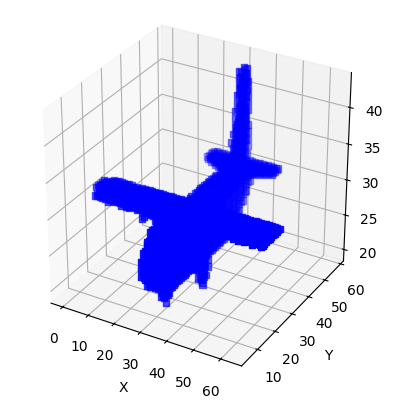

In [17]:
Visualization.matplotlib_visualize_original(original_sample)

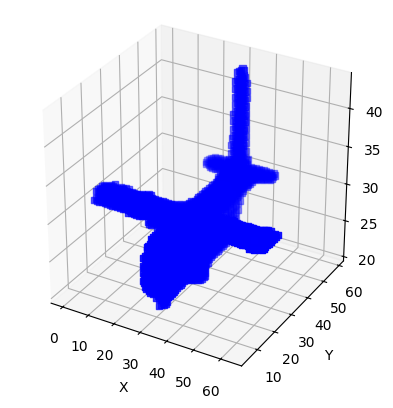

In [22]:
Visualization.matplotlib_visualize_reconstructed(reconstructed_sample)

In [23]:
Visualization.open3d_visualize_original(original_sample)

In [24]:
Visualization.open3d_visualize_reconstructed(reconstructed_sample)